In [117]:
using FFTW, Plots, BenchmarkTools, Statistics

In [210]:
t=1:1000

struct TS
    w
    a
    p
end

function g(t,s::TS)
    o=zeros(length(t))
    for n in 1:length(t)
        o[n]+=sum(s.a.*sin.((t[n]./s.w.*2 .*pi).+s.p))
    end
    return o
end
N=500
range(0,stop=2*pi,length=10)
ts=TS(collect(range(1.0,stop=1/N,length=N)),collect(range(0.01,stop=1.,length=N)),rand(N)*2*pi)

TS([1.0, 0.998, 0.996, 0.994, 0.992, 0.99, 0.988, 0.986, 0.984, 0.982  …  0.02, 0.018, 0.016, 0.014, 0.012, 0.01, 0.008, 0.006, 0.004, 0.002], [0.01, 0.011984, 0.0139679, 0.0159519, 0.0179359, 0.0199198, 0.0219038, 0.0238878, 0.0258717, 0.0278557  …  0.982144, 0.984128, 0.986112, 0.988096, 0.99008, 0.992064, 0.994048, 0.996032, 0.998016, 1.0], [5.342, 0.592, 4.63168, 1.54933, 1.03621, 5.94332, 5.24578, 1.41575, 1.02976, 1.96093  …  5.50565, 3.78708, 2.12748, 0.508949, 2.01443, 0.419967, 3.92619, 2.42827, 0.687995, 4.63757])

In [211]:
@benchmark g(t,ts)

BenchmarkTools.Trial: 
  memory estimate:  4.28 MiB
  allocs estimate:  16979
  --------------
  minimum time:     18.020 ms (0.00% GC)
  median time:      19.867 ms (0.00% GC)
  mean time:        20.712 ms (2.83% GC)
  maximum time:     31.770 ms (9.48% GC)
  --------------
  samples:          242
  evals/sample:     1

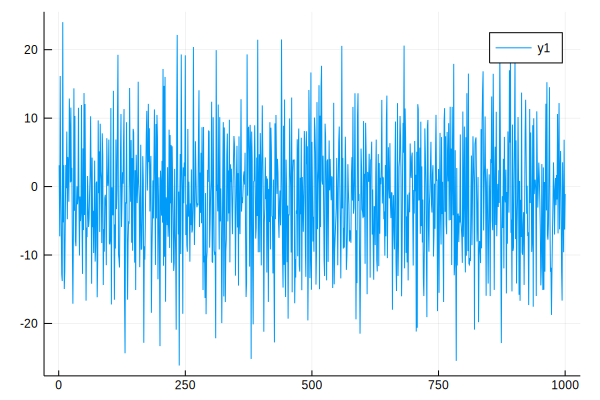

In [218]:
x=g(t,ts)
plot(g(t,ts))

In [213]:
t=1:1000

x=sin.(t/100 .*2*pi.-1.54)+cos.(t/50 .*2*pi.-0.2)+0.5.*sin.(t/25 .*2*pi.+4.2)+cos.(t/5 .*2*pi)+cos.(t/15 .*2*pi)
fft(x)

1000-element Array{Complex{Float64},1}:
  -2.787164595109374 + 0.0im                
 -2.7879173497206713 + 0.03700306343489953im
 -2.7901776480856055 + 0.07405540155305562im
  -2.793951607558623 + 0.11120651121222205im
  -2.799249469773835 + 0.14850633573075758im
 -2.8060856703228527 + 0.1860054934175046im 
 -2.8144789375438437 + 0.22375551256511633im
  -2.824452421686909 + 0.26180907521855723im
 -2.8360338561342373 + 0.30022027218180347im
  -2.849255752787327 + 0.3390448719229582im 
 -500.67419712717526 - 46.36738207288648im  
 -2.8807763058337277 + 0.4181674760129544im 
   -2.89916617149707 + 0.4585880801715261im 
                     ⋮                      
 -2.8991661714970505 - 0.4585880801715305im 
 -2.8807763058337272 - 0.4181674760129539im 
 -500.67419712717515 + 46.3673820728865im   
  -2.849255752787327 - 0.3390448719229582im 
  -2.836033856134236 - 0.3002202721818037im 
 -2.8244524216869076 - 0.261809075218558im  
  -2.814478937543832 - 0.22375551256512605im
  -2.8060856703

In [214]:
function periodogram(x::Vector)
    n = length(x)
    I_w = abs.(fft(x)).^2 ./ n
    w = 2pi * (0:n-1) ./ n  # Fourier frequencies

    # int rounds to nearest integer. We want to round up or take 1/2 + 1 to
    # make sure we get the whole interval from [0, pi]
    ind = iseven(n) ? round(Int, n / 2  + 1) : ceil(Int, n / 2)
    w, I_w = w[1:ind], I_w[1:ind]
    return w, I_w
end

periodogram (generic function with 1 method)

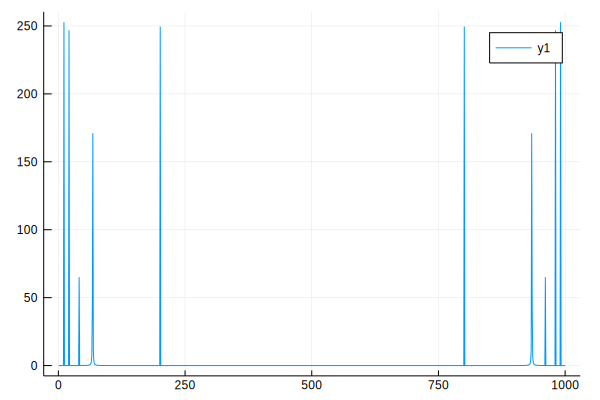

In [215]:
plot(abs.(fft(x)).^2 ./ length(x))

In [219]:
(X,Y)=periodogram(x);

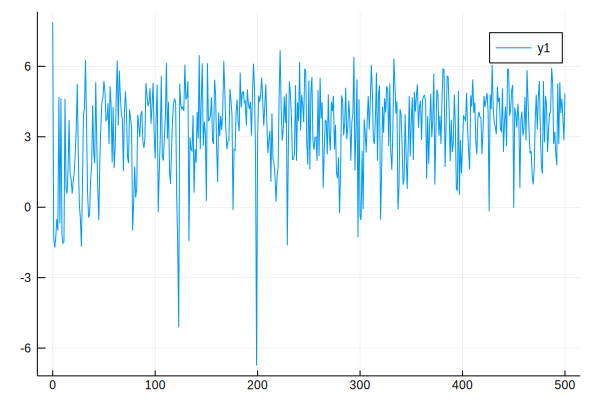

In [222]:
plot((collect(X))./(2*pi)*1000,log.(Y))

##Recipe:

It sounds as though you want to apply an inverse fast Fourier transform (iFFT) to your power spectral density PSD function P(f), in this way transforming from the PSD in frequency domain to time series in time domain, where that time series is random.
To this end, I assume:
  * Your given PDS function is sampled at M positive frequencies f(k) = k X Df, k = 1,2,3…M, where Df is the sample spacing of the PSD function in the frequency domain, and M is the number of samples in the PSD;
  * The number of samples in your given PDS is M = N/2 + 1 where N is the number of samples in the fast Fourier transform (FFT), N = 256, or 1024, or 2048, … or any other integer power of 2, as usual for the FFT; and
  * The maximum frequency in your given PSD is Fmax.
If (1) and (2) are not true, then you must re-sample your PSD such that (1) and (2) are true. If (1) and (2) are true, then you are almost ready to apply an inverse FFT (iFFT) algorithm, which you presumably already have on hand ready to use, in order to generate a corresponding time series.
All you have to do BEFORE applying the inverse FFT (iFFT) is:
  * Convert power PSD(f(k)) to amplitude A(f(k)),  A(f(k)) = SQRT[2 X PSD(f(k))];
  * Give each spectral component a random phase, PHI(f(k)) = random number, uniformly distributed between 0 and 360 degrees (or equivalently, between 0 and 2Pi radians);
  * Construct a frequency domain signal Z(f(k)) = A(f(k)) X e^(i X PHI(f(k))), where i is the imaginary number, i = SQRT(-1)
  
  
Use a uniform random number generator to generate the random phases.
In this way, you have gone from PSD(f(k)) to a corresponding signal in frequency domain Z(f(k)), where Z(f(k)) is ready for input into the inverse FFT (iFFT) algorithm for positive valued (one-sided) functions in frequency f(k) > 0.


Now, finally, apply the inverse FFT (iFFT) to Z(f(k)).
The output of the iFFT will be a random time series on the finite (bounded, limited) time interval t = 0 to tmax = (N-1) X Dt, where Dt = 1 / (2 X Fmax).
The PSD of this time series will be the same as your given PSD.  You should check your result, of course, by taking the FFT of the resulting random time series in order to confirm that it is giving the same PSD as you given PSD.
Note that the time series will repeat itself (no longer random), at times greater than tmax, and at times less than 0. So you cannot generate ever longer time series this way unless you increase N in the sampling of your PSD and in the inverse FFT accordingly.
You can always generate a new random time series by generating a new set of random phases PHI(f(k)) = random number, uniformly distributed between 0 and 360 degrees (or equivalently, between 0 and 2Pi radians), and then applying the iFFT once again. This assumes that the seed of the random number generator is different each time you undertake to generate a new random time series from the given PSD using the steps above.

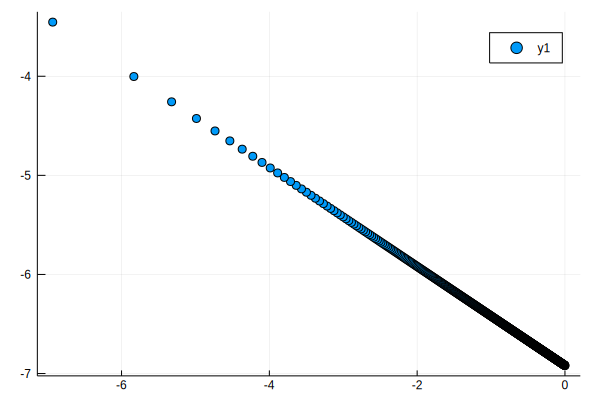

In [308]:
N=1024
M=div(N,2)+1
f=range(1.0,stop=1/1024,length=M)
A=sqrt.(2*(1 ./f.^1.0))
A=A./sum(A)
Z=A.*exp.(rand(M).*2*pi*im)
scatter(log.(f), log.(A))

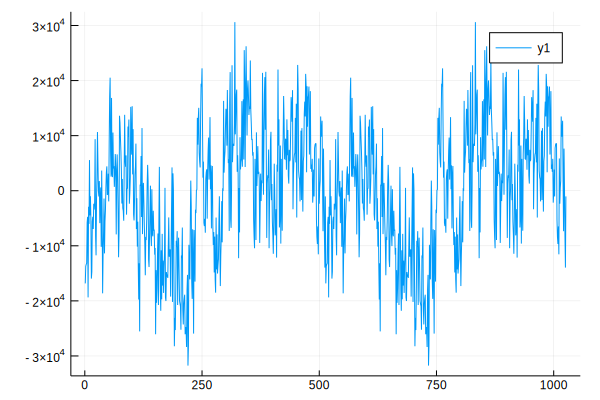

In [309]:
T=real.(ifft(Z))
T/=var(T)
plot(vcat(T,T))

In [310]:
(X,Y)=periodogram(T)

(0.0:0.012247924575398804:3.1354686913020937, [2.37903e7, 7.98782e9, 2.44084e9, 1.83461e9, 1.26311e9, 1.03487e9, 5.96394e8, 7.75328e8, 6.20149e8, 5.89443e8  …  1.99224e7, 5.91015e7, 4.02185e7, 4.27795e7, 6.36037e7, 6.85435e6, 1.95119e7, 1.18295e6, 1.39204e7, 6.29332e7])

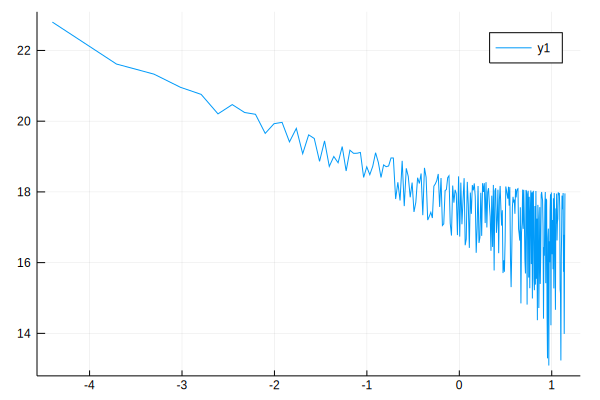

In [311]:
plot(log.(collect(X)),log.(Y))

In [287]:
T./var(T)

513-element Array{Float64,1}:
 -0.0814002371403132  
 -0.07525969150096777 
 -0.06985051327418892 
 -0.06782546001996505 
 -0.06581250753985267 
 -0.06516467740537253 
 -0.06415145927668703 
 -0.06432202237944887 
 -0.060882472903539035
 -0.05636058419904068 
 -0.05524415169376084 
 -0.056712709818409264
 -0.058874779819890644
  ⋮                   
 -0.09152194180801343 
 -0.09194846644099593 
 -0.09245435181004695 
 -0.09034273408092089 
 -0.0898071286234068  
 -0.08994885357577206 
 -0.08880991837059021 
 -0.08899941483455627 
 -0.09086953096250165 
 -0.09031503236365178 
 -0.08723413097211631 
 -0.0858725423744378  

In [53]:
collect(w)

100-element Array{Float64,1}:
 0.0                
 0.06283185307179587
 0.12566370614359174
 0.18849555921538758
 0.25132741228718347
 0.3141592653589793 
 0.37699111843077515
 0.43982297150257105
 0.5026548245743669 
 0.5654866776461628 
 0.6283185307179586 
 0.6911503837897545 
 0.7539822368615503 
 ⋮                  
 5.529203070318036  
 5.592034923389831  
 5.654866776461628  
 5.717698629533423  
 5.780530482605219  
 5.843362335677015  
 5.9061941887488105 
 5.969026041820607  
 6.031857894892402  
 6.094689747964198  
 6.157521601035994  
 6.22035345410779   

In [52]:
w[1:ind]

0.0:0.06283185307179587:3.141592653589793

In [54]:
I_w = abs.(fft(x)).^2 ./ n

100-element Array{Float64,1}:
 29.284312646090708    
  0.08371576378806969  
  0.02112029980681934  
  0.008612004536107037 
  0.0016376063435629678
  0.0036061082958689676
  0.01614938880145607  
  0.16438746452083985  
  0.008119261612423944 
  0.02849009579597054  
  0.02813578341863832  
  0.07873443494966939  
  0.06951486678686945  
  ⋮                    
  0.06951486678686948  
  0.07873443494966942  
  0.02813578341863832  
  0.028490095795970522 
  0.00811926161242394  
  0.16438746452083985  
  0.016149388801456086 
  0.0036061082958689723
  0.0016376063435629674
  0.008612004536107037 
  0.02112029980681934  
  0.08371576378806972  

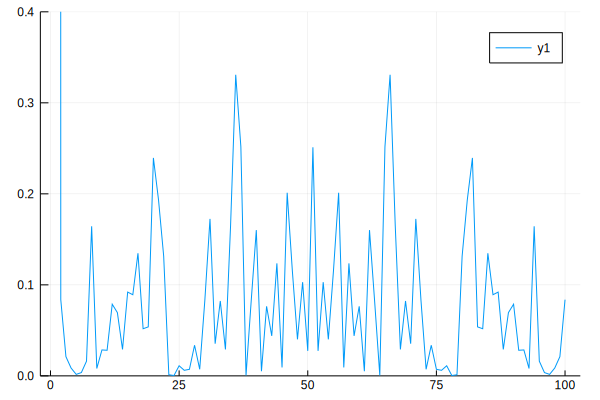

In [57]:
plot(I_w, ylim=(0.0,0.4))

In [79]:
@btime ifft(fft(x))

  58.504 μs (113 allocations: 53.64 KiB)


1000-element Array{Complex{Float64},1}:
   1.6126121023835935 - 3.737161773123072e-17im 
   0.7666530744197032 + 1.9833328862746918e-16im
   0.9926879120277172 - 1.3278945683939985e-16im
    2.278341487085681 - 7.050680075675448e-17im 
    3.069090505045048 + 4.678269905589378e-17im 
    2.404136902909309 - 6.05462605173407e-16im  
    1.236473537667504 - 1.3842306074447208e-16im
   1.1133905271717837 - 3.3891993512720444e-17im
   2.0411363236948055 - 2.3891980194030067e-17im
    2.484587498959894 + 4.570731486792051e-17im 
   1.5019468513940404 + 6.825208997238966e-17im 
  0.06365386464736006 - 2.043552357774666e-16im 
   -0.268172120047154 + 8.452668612662465e-18im 
                      ⋮                         
  -0.5091502334728143 + 5.596348964918757e-16im 
   0.1334464897900001 - 1.1278394773914328e-17im
  -0.5715437518147674 - 2.5526213053733743e-16im
  -1.6597709259636573 + 4.581313987471477e-16im 
  -1.5796595469200834 + 2.698743703051221e-16im 
 -0.32816565931673247 + 2.750

In [315]:
gr()

Plots.GRBackend()

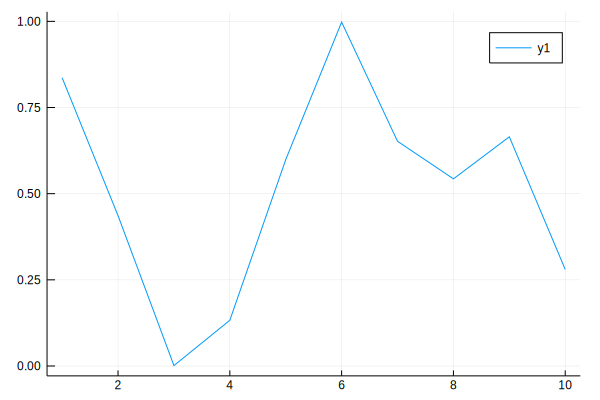

In [316]:
plot(rand(10))